In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from time import time

from ipywidgets import interact, interact_manual, FloatSlider
import pandas as pd
import numpy as np
import torch

In [2]:
import torch
from torch_geometric.data import Data
## Create an undirected graph having three nodes (0, 1, 2).
## Nodes 0 and 1 are connected; nodes 1 and 2 are connected (in both directions).
## Each node has a single feature. These features are equal to
## -1, 0, 1 for the three nodes respectively, in this order.
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

G1 = Data(x=x, edge_index=edge_index)

In [3]:
def is_undirected(graph):
  ## TODO: implement me!
  pass

In [4]:
# Solution 1. (Assuming there are no self loops).
from collections import Counter

def is_undirected(graph):
  edge_index = graph.edge_index

  pair_dict = Counter()
  for idx in range(edge_index.shape[1]):
    u = int(edge_index[0, idx])
    v = int(edge_index[1, idx])

    source = min(u, v)
    target = max(u, v)

    key = (source, target)
    pair_dict[key] +=1

  return all(value == 2 for value in pair_dict.values())

In [5]:
# Solution 2. (with PyTorch Geometric coalesce method)
from torch_sparse import coalesce
def is_undirected(graph):
  edge_index, num_nodes = graph.edge_index, graph.num_nodes

  edge_index, _ = coalesce(edge_index, None, num_nodes, num_nodes)

  sources, targets = edge_index
  sources_and_targets = torch.cat([sources, targets], dim=0)
  targets_and_sources = torch.cat([targets, sources], dim=0)

  undirected_edge_index = torch.stack([sources_and_targets, targets_and_sources], dim=0)
  undirected_edge_index, _ = coalesce(undirected_edge_index, None, num_nodes, num_nodes)

  return edge_index.size(1) == undirected_edge_index.size(1)

In [6]:
print("Your function works correctly on G1: ", G1.is_undirected() == is_undirected(G1))

# Let us check the result on a second graph
edge_index = torch.tensor([[0, 1, 1],
                           [1, 0, 2]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

G2 = Data(x=x, edge_index=edge_index)

print("Your function works correctly on G2: ", G2.is_undirected() == is_undirected(G2))

Your function works correctly on G1:  True
Your function works correctly on G2:  True


In [7]:
# Atom types, ordered accroding to one-hot-encoding
MUT_LABEL_ENC = pd.Series(data = ['C','N','O','F', 'I', 'Cl', 'Br'])
print("Number of different elements: ", len(MUT_LABEL_ENC))

# Define transform
class AddSymbols(object):
    """
    Add the symbol of the elements, from the atomic number, as a key of the graph
    """
    def __call__(self, graph):
        graph.symbols = MUT_LABEL_ENC.loc[graph.x.argmax(dim=-1)].values
       
        return graph

Number of different elements:  7


In [8]:
MUT_LABEL_ENC

0     C
1     N
2     O
3     F
4     I
5    Cl
6    Br
dtype: object

In [9]:
from torch_geometric.datasets import TUDataset

# Load the dataset
dataset = TUDataset(
    './dataset/mutag/',
    name='MUTAG',
    use_node_attr=True,
    use_edge_attr=True,
    transform=AddSymbols(),
)

In [10]:
 MUT_LABEL_ENC.loc[dataset[0].x.argmax(dim=-1)].values

array(['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'N', 'O', 'O'], dtype=object)

In [11]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Samples per class: {[ np.sum([1 for graph in dataset if graph.y == i ]) for i in range(dataset.num_classes) ]}')

all_atoms = np.concatenate(
    [graph.symbols for graph in dataset]
)
print(f"{len(np.unique(all_atoms))} unique atoms: {np.unique(all_atoms)}")


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2
Samples per class: [63, 125]
7 unique atoms: ['Br' 'C' 'Cl' 'F' 'I' 'N' 'O']


In [16]:
size=0
for i, mutag_data in enumerate(dataset[:188]):
    size += mutag_data.x.size()[0]
print(size/188)

17.930851063829788


In [17]:
sparisty = 10/(size/188)
print(sparisty)

0.5576980124592109


In [12]:
G = dataset[0]  # Get the first graph object.
print(G)
# Gather some statistics about the first graph.
print(f'Number of nodes: {G.num_nodes}')
print(f'Number of edges: {G.num_edges}')
print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
print(f'Contains isolated nodes: {G.has_isolated_nodes()}')
print(f'Contains self-loops: {G.has_self_loops()}')
print(f'Is undirected: {G.is_undirected()}')

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1], symbols=[17])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [13]:
import networkx as nx
from torch_geometric.utils import to_networkx  # Conversion function

In [14]:
G = dataset[2]
## TO DO: draw G!

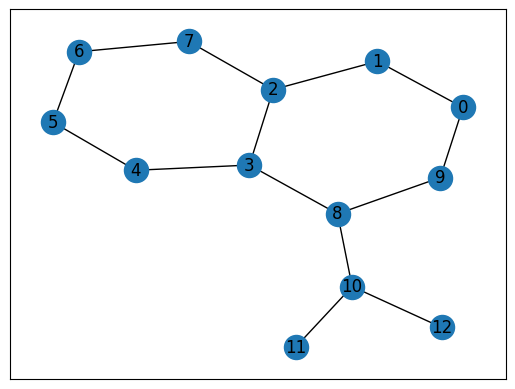

In [15]:
## Solution
G = dataset[2]
G = to_networkx(G, to_undirected=True)
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos)

In [16]:
from src import plot_mol

In [17]:
interact(
    lambda graph: plot_mol(
        dataset[graph],
        edge_type=dataset[graph].edge_attr[:,0].numpy(),
    ),
    graph=range(len(dataset))
)

interactive(children=(Dropdown(description='graph', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.<lambda>(graph)>

In [18]:
from torch_geometric.data import DataLoader

loader = DataLoader(dataset, batch_size=32, shuffle=True)
data_batch = next(iter(loader))
print(data_batch)
print("Number of graphs in the batch:",data_batch.num_graphs)

DataBatch(edge_index=[2, 1246], x=[567, 7], edge_attr=[1246, 4], y=[32], symbols=[32], batch=[567], ptr=[33])
Number of graphs in the batch: 32


/home/r20user12/anaconda3/envs/XGNN/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [19]:
## Solution
class GraphConvolution(torch.nn.Module):
  def __init__(self, num_input_features, num_output_features):
    super().__init__()
    self.W1 = torch.nn.Parameter(torch.randn(num_input_features, num_output_features)*0.1)
    self.W2 = torch.nn.Parameter(torch.randn(num_input_features, num_output_features)*0.1)
    
  def forward(self, x, edge_index):
    adj = to_dense_adj(edge_index)
    neighbors_aggregation = adj @ x
    out = x @ self.W1 + neighbors_aggregation @ self.W2
    return out

In [20]:
from typing import Optional

import torch
from torch import Tensor

from torch_geometric.typing import OptTensor
from torch_geometric.utils import scatter


def to_dense_adj(
    edge_index: Tensor,
    batch: OptTensor = None,
    edge_attr: OptTensor = None,
    max_num_nodes: Optional[int] = None,
    batch_size: Optional[int] = None,
) -> Tensor:
    r"""Converts batched sparse adjacency matrices given by edge indices and
    edge attributes to a single dense batched adjacency matrix.

    Args:
        edge_index (LongTensor): The edge indices.
        batch (LongTensor, optional): Batch vector
            :math:`\mathbf{b} \in {\{ 0, \ldots, B-1\}}^N`, which assigns each
            node to a specific example. (default: :obj:`None`)
        edge_attr (Tensor, optional): Edge weights or multi-dimensional edge
            features. (default: :obj:`None`)
        max_num_nodes (int, optional): The size of the output node dimension.
            (default: :obj:`None`)
        batch_size (int, optional) The batch size. (default: :obj:`None`)

    :rtype: :class:`Tensor`

    Examples:

        >>> edge_index = torch.tensor([[0, 0, 1, 2, 3],
        ...                            [0, 1, 0, 3, 0]])
        >>> batch = torch.tensor([0, 0, 1, 1])
        >>> to_dense_adj(edge_index, batch)
        tensor([[[1., 1.],
                [1., 0.]],
                [[0., 1.],
                [1., 0.]]])

        >>> to_dense_adj(edge_index, batch, max_num_nodes=4)
        tensor([[[1., 1., 0., 0.],
                [1., 0., 0., 0.],
                [0., 0., 0., 0.],
                [0., 0., 0., 0.]],
                [[0., 1., 0., 0.],
                [1., 0., 0., 0.],
                [0., 0., 0., 0.],
                [0., 0., 0., 0.]]])

        >>> edge_attr = torch.Tensor([1, 2, 3, 4, 5])
        >>> to_dense_adj(edge_index, batch, edge_attr)
        tensor([[[1., 2.],
                [3., 0.]],
                [[0., 4.],
                [5., 0.]]])
    """
    if batch is None:
        num_nodes = int(edge_index.max()) + 1 if edge_index.numel() > 0 else 0
        batch = edge_index.new_zeros(num_nodes)

    if batch_size is None:
        batch_size = int(batch.max()) + 1 if batch.numel() > 0 else 1

    one = batch.new_ones(batch.size(0))
    num_nodes = scatter(one, batch, dim=0, dim_size=batch_size, reduce='sum')
    cum_nodes = torch.cat([batch.new_zeros(1), num_nodes.cumsum(dim=0)])

    idx0 = batch[edge_index[0]]
    idx1 = edge_index[0] - cum_nodes[batch][edge_index[0]]
    idx2 = edge_index[1] - cum_nodes[batch][edge_index[1]]

    if max_num_nodes is None:
        max_num_nodes = int(num_nodes.max())

    elif ((idx1.numel() > 0 and idx1.max() >= max_num_nodes)
          or (idx2.numel() > 0 and idx2.max() >= max_num_nodes)):
        mask = (idx1 < max_num_nodes) & (idx2 < max_num_nodes)
        idx0 = idx0[mask]
        idx1 = idx1[mask]
        idx2 = idx2[mask]
        edge_attr = None if edge_attr is None else edge_attr[mask]

    if edge_attr is None:
        edge_attr = torch.ones(idx0.numel(), device=edge_index.device)

    size = [batch_size, max_num_nodes, max_num_nodes]
    size += list(edge_attr.size())[1:]
    flattened_size = batch_size * max_num_nodes * max_num_nodes

    idx = idx0 * max_num_nodes * max_num_nodes + idx1 * max_num_nodes + idx2
    adj = scatter(edge_attr, idx, dim=0, dim_size=flattened_size, reduce='sum')
    adj = adj.view(size)

    return adj

In [21]:
# You may test that your class does not throw errors and
# at least the correctness of dimensionality with the following lines
G = dataset[0]
x = G.x
print(x.shape)

edge_index = G.edge_index
conv = GraphConvolution(7,5)

out = conv(x, edge_index)

print(out.shape)

torch.Size([17, 7])
torch.Size([1, 17, 5])


In [22]:
from torch.nn import Linear, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_add_pool

## Solution
class GNN(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        hidden_dim,
        node_features_dim,
        edge_features_dim=None
    ):
        super(GNN, self).__init__()
        self.hidden_dim = hidden_dim

        self.conv1 = GraphConv(node_features_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)
        self.conv4 = GraphConv(hidden_dim, hidden_dim)
        self.conv5 = GraphConv(hidden_dim, hidden_dim)

        self.fc1 = Linear(hidden_dim, hidden_dim)
        self.fc2 = Linear(hidden_dim, num_classes)

        self.readout = LogSoftmax(dim=-1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return self.readout(x)

In [23]:
from torch_geometric.loader import DataLoader
from tqdm.auto import tqdm

# If possible, we use a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

idx_train_end = int(len(dataset) * .5)
idx_valid_end =  int(len(dataset) * .7)

BATCH_SIZE = 128
BATCH_SIZE_TEST = len(dataset) - idx_valid_end

# In the test loader we set the natch size to be equal to the size of the whole test set 
loader_train = DataLoader(dataset[:idx_train_end], batch_size=BATCH_SIZE, shuffle=True)
loader_valid = DataLoader(dataset[idx_train_end:idx_valid_end], batch_size=BATCH_SIZE, shuffle=True)
loader_test = DataLoader(dataset[idx_valid_end:], batch_size=BATCH_SIZE_TEST, shuffle=False)

Using device: cuda


In [24]:
from torch.nn import NLLLoss

# Model
model = GNN(
    num_classes = 2,
    hidden_dim=64,
    node_features_dim=dataset.num_node_features,
).to(device)

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters())

# Loss function
loss_function = NLLLoss()

In [25]:
from src import compute_accuracy

def train_model(loader_train, loader_valid, model, optimizer, loss_function, N_EPOCHS):
  # Prepare empy lists for logging
  train_losses = []
  train_accs = []
  val_accs = []

  for epoch in tqdm(range(N_EPOCHS)):
      epoch_loss = 0
      for batch in tqdm(loader_train, leave=False):
          batch.to(device)

          out = model(batch.x, batch.edge_index, batch.batch)
          loss = loss_function(out, batch.y.flatten())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          acc_train = compute_accuracy(model, loader_train)
          acc_valid = compute_accuracy(model, loader_valid)

          with torch.no_grad():
            train_accs.append(acc_train)
            val_accs.append(acc_valid)
            train_losses.append(loss)

      print(f"Epoch: {epoch}, Loss: {loss}")

  # Visualization at the end of training
  fig, ax = plt.subplots(dpi=100)
  ax.plot(train_accs, c="steelblue", label="Training")
  ax.plot(val_accs, c="orangered", label="Validation")
  ax.grid()
  ax.legend()
  ax.set_title("Accuracy evolution")
  plt.show()

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0, Loss: 1.483071208000183


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.9037643074989319


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.758192241191864


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.5084604024887085


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.6147269606590271


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.5209648609161377


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.44921693205833435


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.4552399218082428


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.45530304312705994


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.4386717677116394


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.42576083540916443


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.43240055441856384


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.43285301327705383


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.417463093996048


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.4084773063659668


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.40894755721092224


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.40430471301078796


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.3925054967403412


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.392137736082077


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.3916266858577728


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.3780669867992401


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.3768235743045807


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.3746756613254547


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.3653525114059448


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.3646036386489868


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.36062631011009216


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.35288864374160767


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.3515460193157196


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.3429068624973297


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.33941543102264404


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.33353713154792786


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.32883524894714355


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.32401761412620544


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.31814101338386536


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.3113850951194763


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.3075234293937683


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.3002157211303711


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.29566824436187744


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.29246777296066284


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 39, Loss: 0.2858036458492279


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 40, Loss: 0.2778918147087097


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.2727063000202179


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 42, Loss: 0.2715602219104767


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 43, Loss: 0.2839442491531372


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.30611932277679443


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.3156130909919739


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 46, Loss: 0.26140445470809937


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.3298982083797455


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.271911084651947


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 49, Loss: 0.3005157709121704


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 50, Loss: 0.25355565547943115


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 51, Loss: 0.2920514643192291


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 52, Loss: 0.25518184900283813


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 53, Loss: 0.2853732705116272


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 54, Loss: 0.2407132238149643


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 55, Loss: 0.28235042095184326


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 56, Loss: 0.23609194159507751


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 57, Loss: 0.269317090511322


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 58, Loss: 0.23418177664279938


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 59, Loss: 0.2608545124530792


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 60, Loss: 0.23018310964107513


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 61, Loss: 0.24769899249076843


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 62, Loss: 0.23084045946598053


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 63, Loss: 0.23578797280788422


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 64, Loss: 0.22561080753803253


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 65, Loss: 0.22772687673568726


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 66, Loss: 0.22390426695346832


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 67, Loss: 0.21903465688228607


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 68, Loss: 0.21809779107570648


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 69, Loss: 0.21492168307304382


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 70, Loss: 0.2124897539615631


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 71, Loss: 0.20972295105457306


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 72, Loss: 0.2043861448764801


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 73, Loss: 0.20563606917858124


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 74, Loss: 0.19785498082637787


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 75, Loss: 0.20286867022514343


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 76, Loss: 0.19180870056152344


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 77, Loss: 0.19591335952281952


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 78, Loss: 0.18788908421993256


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 79, Loss: 0.1861112117767334


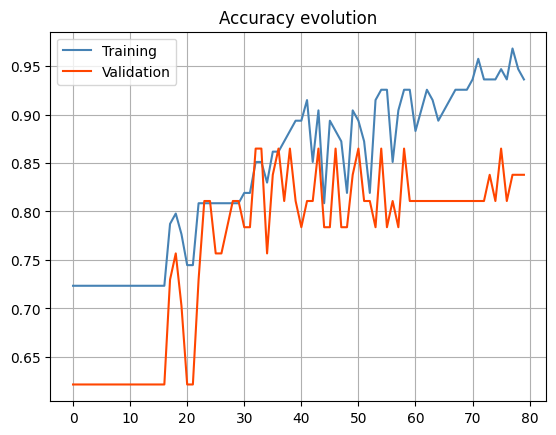

In [26]:
N_EPOCHS = 80
train_model(loader_train, loader_valid, model, optimizer, loss_function, N_EPOCHS)

In [27]:
from torch_geometric.nn import MessagePassing
# Solution

def graph_loss(
    x: torch.tensor,                     
    edge_index: torch.tensor,
    batch_index: torch.tensor,
    node_feat_mask: torch.nn.Parameter, 
    edge_mask: torch.nn.Parameter,      
    expl_label: int,
    model) -> torch.tensor:
    """
    Computes the explainer loss function for explanation
    of graph classificaiton tasks.

    Args:
        x : torch.Tensor
            Feature matrix of datapoint to explain.
        edge_index : torch.LongTensor
            A Tensor that defines the underlying graph connectivity/message
            passing flow. `edge_index` holds the indices of a general (sparse)
            assignment matrix of shape `[N, M]`. Its shape must be defined as
            `[2, num_messages]`, where messages from nodes in `edge_index[0]`
            are sent to nodes in `edge_index[1]`.
        batch_index : torch.LongTensor
            Column vector which maps each node to its respective graph in the batch.
        node_feat_mask : torch.nn.Parameter
            representing node feature mask of size [n_features]
        edge_mask : torch.nn.Parameter
            representing edge mask of size [n_edges]
        expl_label : int
            Label with respect to which we want the explanation.
        model : nn.Module
            a (pretrained) model
    Returns:
        loss (torch.tensor): explainer loss function, which
            is a weight sum of different terms.
    """
    EPS = 1e-15

    # Apply sigmoid to masks
    edge_mask = edge_mask.sigmoid()
    node_feat_mask = node_feat_mask.sigmoid()

    # Loss terms weights
    coeffs = {"edge_size":0.01,
            "node_feat_size":0.07,
            "edge_entropy":1.0}

    # Mask node features
    h = x * node_feat_mask

    # Mask edges: instead of applying the mask on edge_index, make the model
    # aware of the mask
    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.__explain__ = True
            module.__edge_mask__ = edge_mask

    # Compute model output (we assume the model already gives log probabilities)
    model_pred_log_proba = model(h, edge_index, batch_index)

    # Prediction loss.
    pred_loss = -model_pred_log_proba[:, expl_label]

    # Edge mask size loss.
    edge_mask_size_loss = edge_mask.sum()

    # Edge mask entropy loss.
    ent_loss = (-edge_mask * torch.log(edge_mask + EPS) -
                (1 - edge_mask) * torch.log(1 - edge_mask + EPS)).mean()

    # Feature mask size loss.
    feat_mask_size_loss = node_feat_mask.sum()

    # Sum all loss terms
    loss = pred_loss + \
           coeffs['edge_size'] * edge_mask_size_loss + \
           coeffs['edge_entropy'] *ent_loss + \
           coeffs['node_feat_size'] * feat_mask_size_loss

    return loss.sum()

In [28]:
## Test your loss implementation does not throw any errors
import math
from copy import deepcopy
data_batch = next(iter(loader)).to(device)

x = data_batch.x
edge_index = data_batch.edge_index
batch_index = data_batch.batch

(nodes, feat), edges = x.size(), edge_index.size(1)

# Feat mask
node_feat_mask = torch.nn.Parameter(torch.randn(feat, device=device) * 0.1)

# Edge mask.
edge_mask = torch.nn.Parameter(torch.randn(edges, device=device) * 0.1)

expl_label = 1

loss = graph_loss(x,                     
    edge_index,
    batch_index,
    node_feat_mask, 
    edge_mask,      
    expl_label,
    deepcopy(model))

print(f"Computed loss : {round(loss.item(), 2)}")

Computed loss : 353.11


In [29]:
from src import GNNExplainer

In [91]:
def visualize_subgraph_mutag(graph: nx.Graph,
                             edge_set: torch.Tensor,
                             title: Optional[str] = None) -> None:
    """Visualizes a subgraph explanation for a graph from the MUTAG dataset.

    Note: Only provide subgraph_node_set or subgraph_edge_set, not both.

    Adapted from https://github.com/divelab/DIG/blob/dig/dig/xgraph/method/subgraphx.py

    :param graph: A NetworkX graph object representing the full graph.
    :param node_set: A set of nodes that induces a subgraph.
    :param edge_set: A set of edges that induces a subgraph.
    :param title: Optional title for the plot.
    """
    node_set = set(graph.symbols)

    if edge_set is None:
        edge_set = {(n_from, n_to) for (n_from, n_to) in graph.edges() if n_from in node_set and n_to in node_set}

    node_dict = {0: 'C', 1: 'N', 2: 'O', 3: 'F', 4: 'I', 5: 'Cl', 6: 'Br'}
    node_dict2 = {'C':0, 'N':1, 'O':2, 'F':3, 'I':4, 'Cl':5, 'Br':6}
    sett = {}
    for i in range(len(graph.symbols)):
        sett[i] = node_dict2[graph.symbols[i]]
    node_idxs = sett
    node_labels = {k: node_dict[v] for k, v in node_idxs.items()}
    node_color = ['#E49D1C', '#4970C6', '#FF5357', '#29A329', 'brown', 'darkslategray', '#F0EA00']
    colors = [node_color[v % len(node_color)] for k, v in node_idxs.items()]
    
    graph2 = to_networkx(graph, node_attrs=['x'], edge_attrs=['edge_attr'], to_undirected=True)
    pos = nx.kamada_kawai_layout(graph2)
    
    new_e1=[]
    new_e2=[]
    e_list = []
    for j in range(len(GNNExp_edge_mask)):
        if float(GNNExp_edge_mask[j]) > 0.3:
            new_e1.append(int(graph.edge_index[0][j]))
            new_e2.append(int(graph.edge_index[1][j]))
            e_list.append((int(graph.edge_index[0][j]), int(graph.edge_index[1][j])))
    new_e= torch.tensor([new_e1, new_e2])
 
    nx.draw_networkx_nodes(G=graph2, pos=pos, nodelist=[i for i in range(len(graph.symbols))], node_color=colors, node_size=300)
    nx.draw_networkx_edges(G=graph2, pos=pos,width=3, edge_color='gray', arrows=False)
    nx.draw_networkx_edges(G=graph2, pos=pos,edgelist=e_list, width=6, edge_color='black', arrows=False)
    nx.draw_networkx_labels(G=graph2, pos=pos,labels=node_labels)

    if title is not None:
        plt.title(title)

    plt.axis('off')
    plt.show()
    plt.close()

0


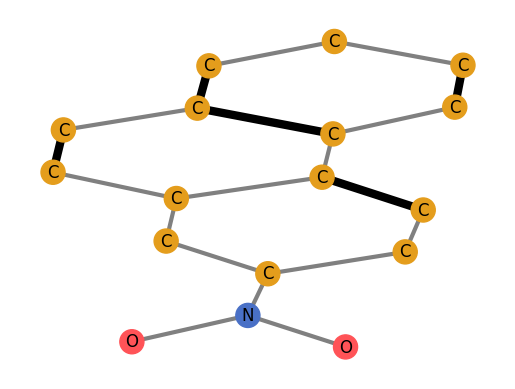

1


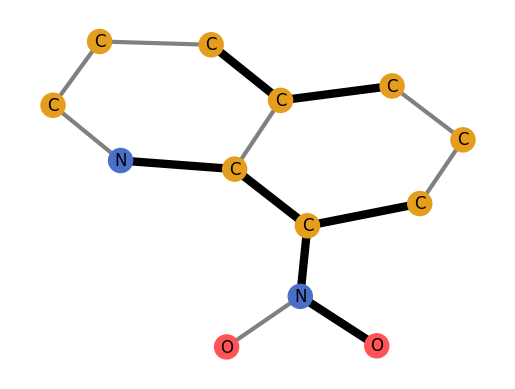

2


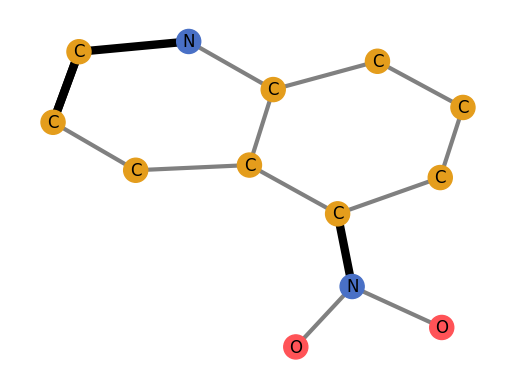

3


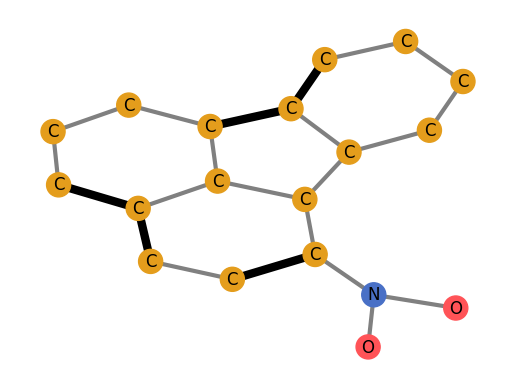

4


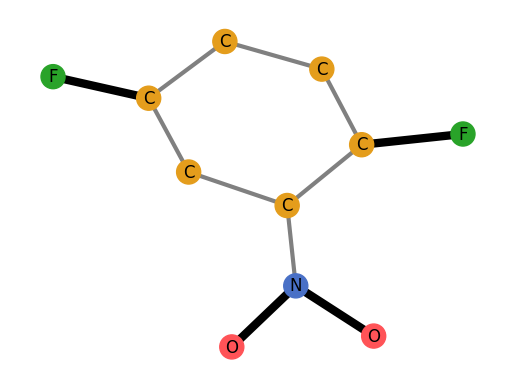

5


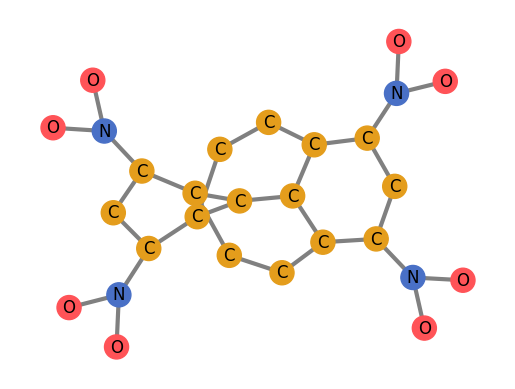

6


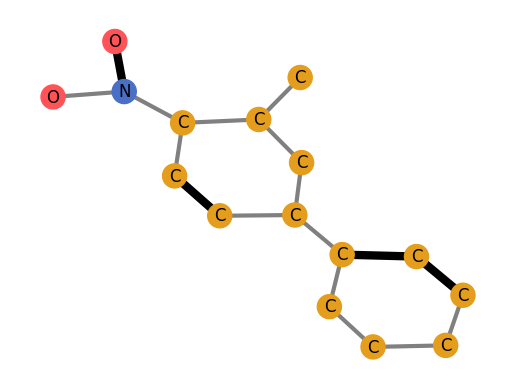

7


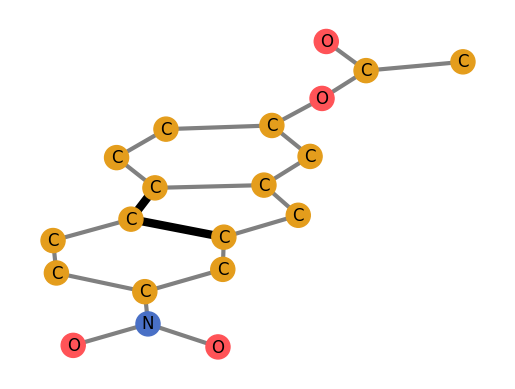

8


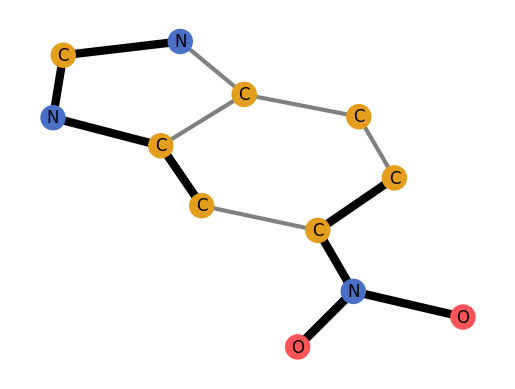

9


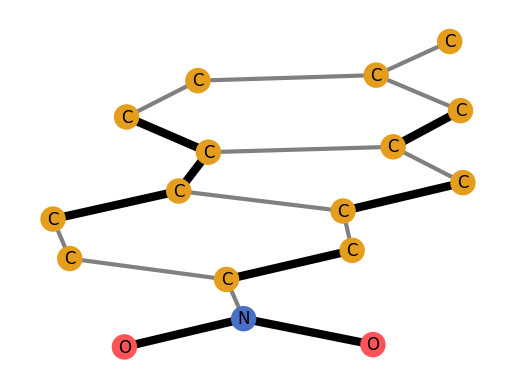

10


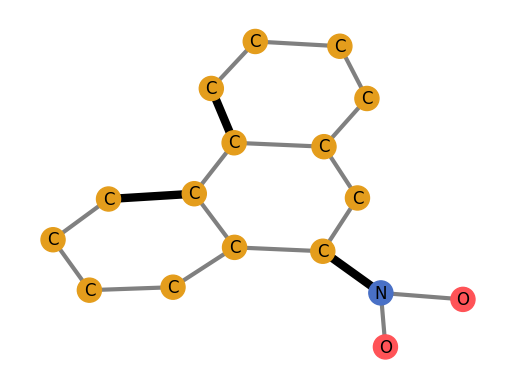

11


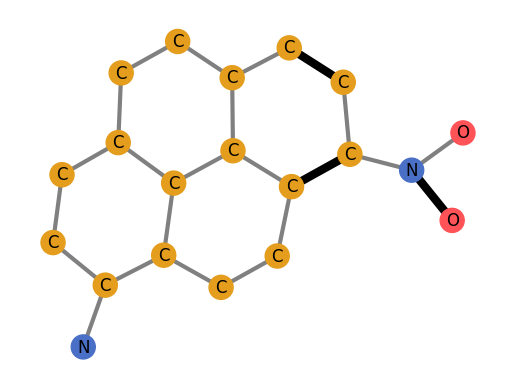

12


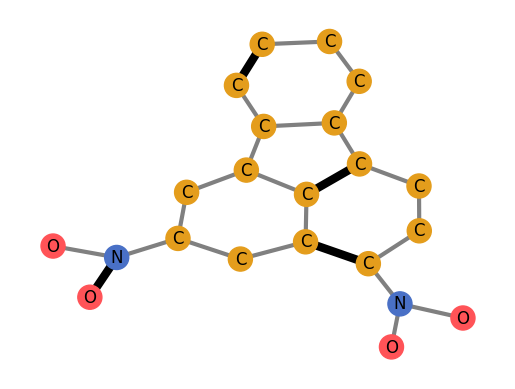

13


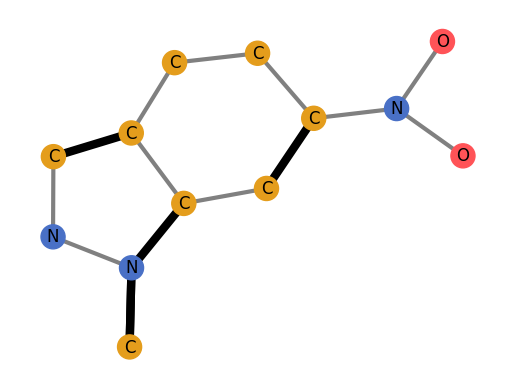

14


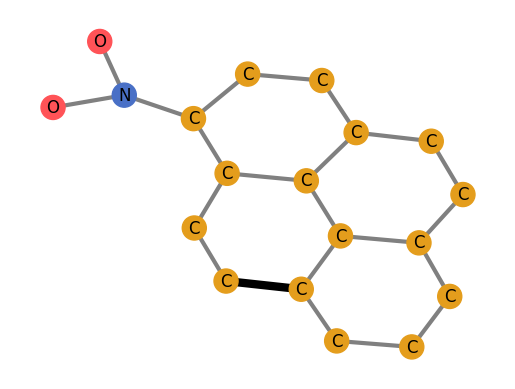

15


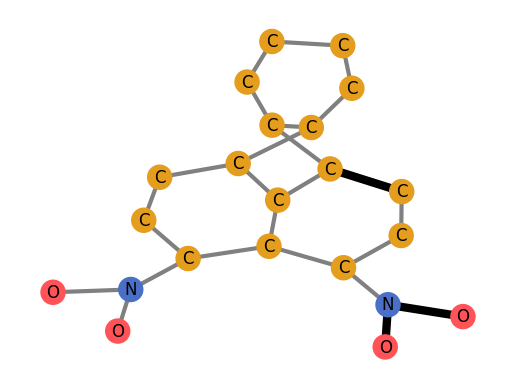

16


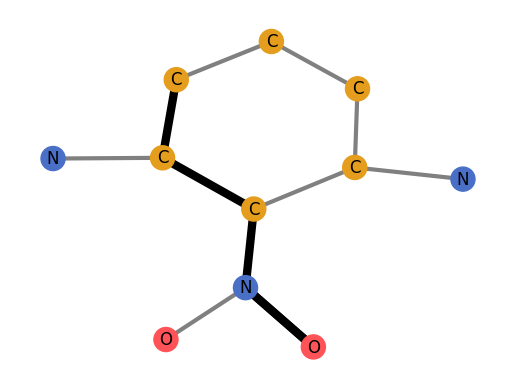

17


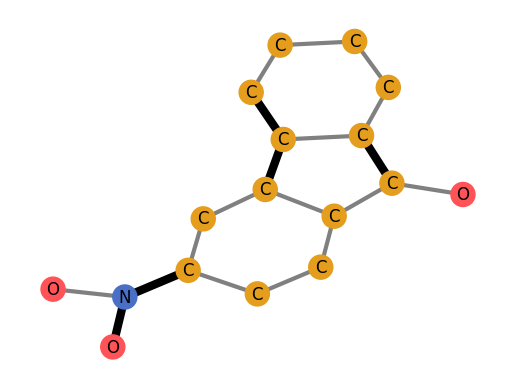

18


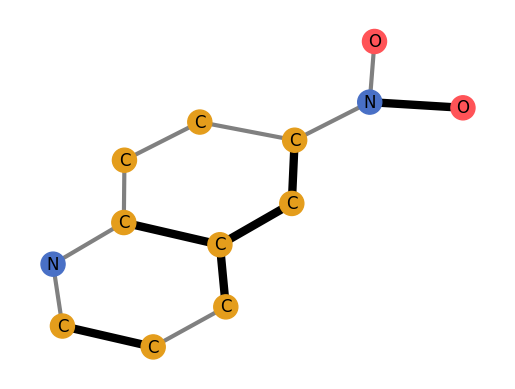

19


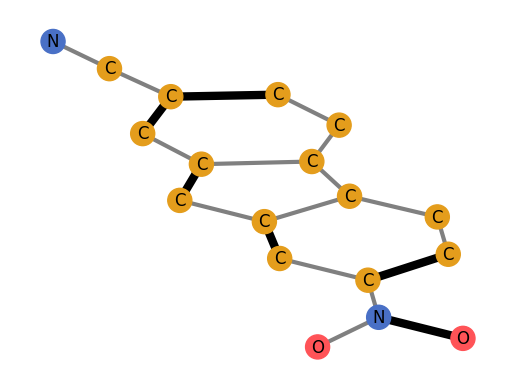

In [92]:
for i in range(20):
    data = dataset[i]
    data.to(device)

    # Initialize explainer
    explainer = GNNExplainer(model, epochs=200).to(device)

    # Train explainer
    model_args = (
        data.x,
        data.edge_index,
        torch.zeros(data.num_nodes, dtype=int, device=device)
    )

    GNNExp_feat_mask, GNNExp_edge_mask = explainer.explain_graph(
        *model_args,
        model(*model_args).argmax(dim=1)
    )

    # Plot the explanation
    print(i)
    visualize_subgraph_mutag(
        graph=data,
        edge_set=GNNExp_edge_mask)